In [1]:
%cd ..

/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection


In [2]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import skimage
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation
import matplotlib.pyplot as plt
%matplotlib inline


from utils.dataset import load_yolo_labels
from utils.intensity_transforms import histogram_matching
from models.kernels import AlexNetDescriptor

In [3]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [4]:
mean_histogram = np.load('mean_hist.npy')

In [5]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Convert boolean mask to 8-bit integer
    binary_mask = binary_mask.astype(np.uint8) * 255  # Convert boolean to uint8
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    # final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))

    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour based on area
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour
    
    # Create a mask for the largest contour
    if largest_contour is not None:
        mask = np.zeros_like(binary_mask)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
        # Apply the mask to the original image
        final_image = cv2.bitwise_and(image, image, mask=mask)
    
    return final_image

## Visualize Preprocess

MLDataset/crop_data/images/train/fracture/1350_1064528986_01_WRI-L1_M005.png


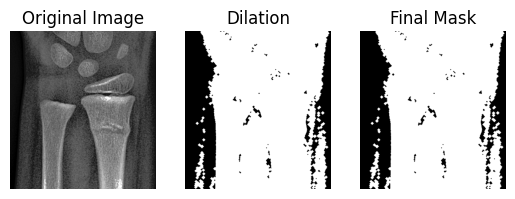

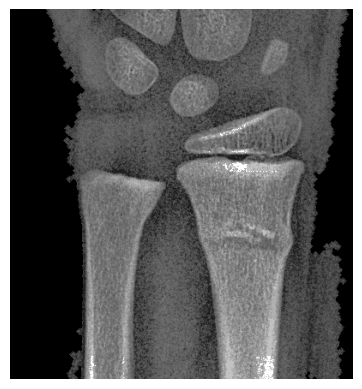

In [17]:
intensity_crop = 1
outputbitdepth = 8 
unsharp = True
dilate_num = 4

for j, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, img_train_folder, 'fracture/*.png'))):
    if j != 4:
        continue
    print(image_path)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    org_image = image.copy()
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Convert boolean mask to 8-bit integer
    binary_mask = binary_mask.astype(np.uint8) * 255  # Convert boolean to uint8
    
    # Apply multiple dilations
    selem = disk(1)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
    max_area = 0
    largest_contour = None
    if contours:
        # Sort contours based on contour area
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Get the two largest contours
        largest_contours = sorted_contours[:1]  # Get the top two largest contours
        
        mask = np.zeros_like(binary_mask)
        cv2.drawContours(mask, largest_contours, -1, (255), thickness=cv2.FILLED)
        
        # Apply the mask to the original image
        final_image = cv2.bitwise_and(image, image, mask=mask)
    

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Dilation')
    plt.imshow(closed_mask, cmap='gray')
    plt.axis('off')
    
    
    plt.subplot(1, 3, 3)
    plt.title('Final Mask')
    plt.imshow(closed_mask, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')
    plt.show()



# Visual Feature Extraction

In [ ]:
from skimage.feature import hog
from skimage.filters import gabor, gabor_kernel
from scipy.ndimage import convolve

mode = 'train'
class_name = 'fracture'

alexnet = AlexNetDescriptor()

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    if idx != 4:
        continue
    # Load the image
    image = preprocess(image)
    # image = skimage.measure.block_reduce(image, (4,4), np.max)

    # Use the Canny edge detector
    edges = cv2.Canny(image, 150, 200)
    
    gabor_f = alexnet(image)
    
    
    fd, hog_image = hog(edges, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    
    fd, hog_image1 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

    # Preprocessed Image
    fig1 = plt.figure()
    # plt.title('Preprocessed Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    fig1.savefig('./images/preprocessed_image_pooled.png', bbox_inches='tight', pad_inches=0)

    # Hog Image
    fig2 = plt.figure()
    # plt.title('Hog')
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    fig2.savefig('./images/hog_image_pooled.png', bbox_inches='tight', pad_inches=0)

    # Gabor Feature
    fig3 = plt.figure()
    # plt.title('Gabor Feature')
    plt.imshow(gabor_f, cmap='gray')
    plt.axis('off')
    fig3.savefig('./images/gabor_image_pooled.png', bbox_inches='tight', pad_inches=0)

    # Canny Image
    fig4 = plt.figure()
    # plt.title('Canny Image')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    fig4.savefig('./images/canny_image_pooled.png', bbox_inches='tight', pad_inches=0)

    # Canny Edges
    fig5 = plt.figure()
    # plt.title('Canny Edges')
    plt.imshow(hog_image1, cmap='gray')
    plt.axis('off')
    fig5.savefig('./images/hogCanny_image_pooled.png', bbox_inches='tight', pad_inches=0)

    plt.show()
    if idx > 10:
        break

## Visualize Gabor Filter

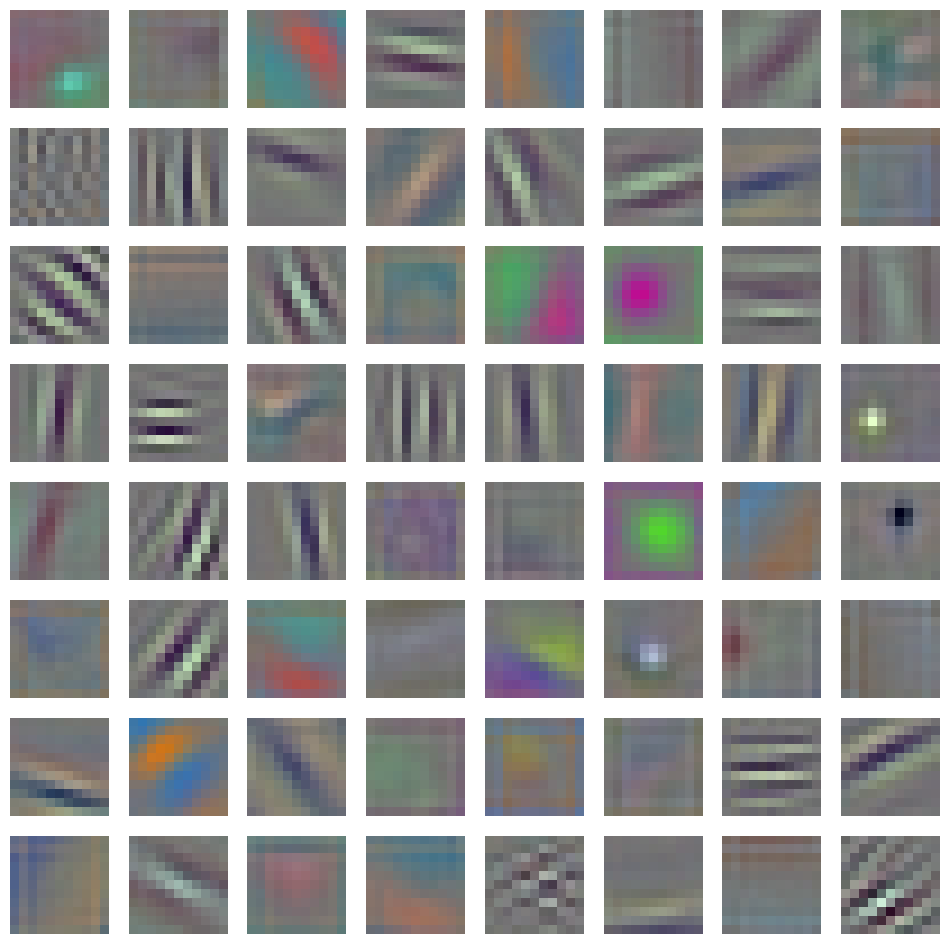

In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load pre-trained AlexNet
model = models.alexnet(pretrained=True)
model.eval()

# Extract the first convolutional layer weights
first_layer = model.features[0]
filters = first_layer.weight.data.clone()

# Normalize filter values to 0-1 so we can visualize them
min_val = filters.min()
max_val = filters.max()
filters = (filters - min_val) / (max_val - min_val)

# Plot the filters
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < filters.shape[0]:
        # The filters have shape (out_channels, in_channels, height, width)
        # For RGB images, in_channels = 3, so we can plot them as RGB images
        filter_img = filters[i].cpu().numpy()
        ax.imshow(np.transpose(filter_img, (1, 2, 0)))  # transpose to (height, width, channels)
    ax.axis('off')
plt.show()

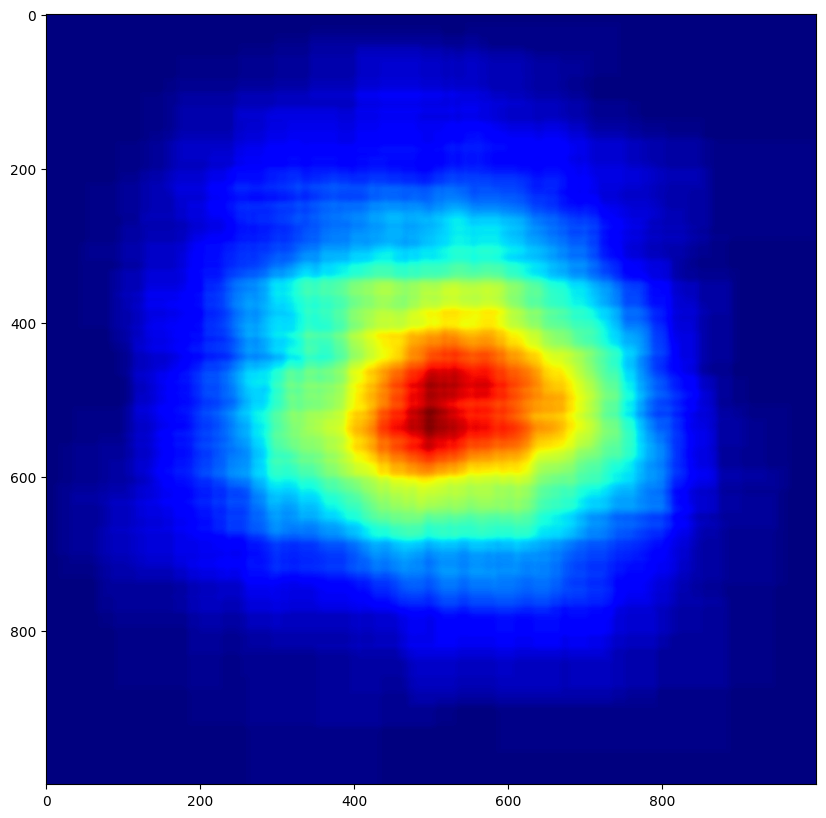

In [69]:
def generate_heatmap_from_folder(image_folder, label_folder, blur=False):
    image_files = glob(os.path.join(image_folder, '*.png'))  # Adjust the extension as needed
    heatmap = None
    image_shape = (1000, 1000)
    
    for image_path in image_files:
        label_path = os.path.join(label_folder, os.path.basename(image_path).replace('.png', '.txt'))
        if not os.path.exists(label_path):
            continue
        
        image = cv2.imread(image_path)
        if heatmap is None:
            # image_shape = image.shape
            heatmap = np.zeros(image_shape[:2], dtype=np.float32)
        
        labels = load_yolo_labels(label_path, image_shape)
        if labels:
            heatmap += create_heatmap(labels, image_shape)
    
    if heatmap is not None and np.any(heatmap):  # Ensure heatmap is not empty
        if blur:
            heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)
        
        heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return heatmap


# Example usage
image_folder = '../MLDataset/crop_data/images/train/fracture/'
label_folder = '../MLDataset/crop_data/labels/train/fracture/'

heatmap = generate_heatmap_from_folder(image_folder, label_folder, blur=True)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='jet')
np.save('crop_heatmap.npy', heatmap)